# 00__preprocess

in this notebook, i upload all individual library/primer sgRNA counts and sum together (after checking correlations) to make 1 dataframe with all sgRNA counts across populations (Day Zero, Endo++, Endo--).

figures in this notebook:
- Fig S5B (heatmap showing biological replicate correlations of sgRNA counts)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pb
import re
import seaborn as sns
import sys

from scipy import stats
from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def to_cpm(df):
    cpm = pd.DataFrame()
    cpm["sgRNA"] = df["sgRNA"]
    for col in df.columns:
        if col not in ["sgRNA"]:
            cpm[col] = df[col]/np.nansum(df[col])*1e6
    return cpm

In [4]:
def pseudocount(df):
    pseudo = pd.DataFrame()
    pseudo["sgRNA"] = df["sgRNA"]
    for col in df.columns:
        if col not in ["sgRNA"]:
            pseudo[col] = df[col] + 1
    return pseudo

## variables

In [5]:
# day zero
day0_lib1_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib1__SetA.sgRNA_counts.txt"
day0_lib1_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib1__SetB.sgRNA_counts.txt"
day0_lib2_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib2__SetA.sgRNA_counts.txt"
day0_lib2_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib2__SetB.sgRNA_counts.txt"
day0_lib3_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib3__SetA.sgRNA_counts.txt"
day0_lib3_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib3__SetB.sgRNA_counts.txt"

day0_lib1_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib1__SetA.sgRNA_counts.txt"
day0_lib1_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib1__SetB.sgRNA_counts.txt"
day0_lib2_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib2__SetA.sgRNA_counts.txt"
day0_lib2_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib2__SetB.sgRNA_counts.txt"
day0_lib3_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib3__SetA.sgRNA_counts.txt"

In [6]:
# BFP+ endo++
bfppos_endopos_lib1_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib1__SetA.sgRNA_counts.txt"
bfppos_endopos_lib1_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib1__SetB.sgRNA_counts.txt"
bfppos_endopos_lib2_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib2__SetA.sgRNA_counts.txt"
bfppos_endopos_lib2_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib2__SetB.sgRNA_counts.txt"

bfppos_endopos_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep2__Lib1__SetA.sgRNA_counts.txt"
bfppos_endopos_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep2__Lib1__SetB.sgRNA_counts.txt"

In [7]:
# BFP+ endo--
bfppos_endoneg_lib1_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep1__Lib1__SetA.sgRNA_counts.txt"
bfppos_endoneg_lib2_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep1__Lib2__SetA.sgRNA_counts.txt"


bfppos_endoneg_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep2__Lib1__SetA.sgRNA_counts.txt"
bfppos_endoneg_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep2__Lib1__SetB.sgRNA_counts.txt"

In [8]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri_with_primers.txt"

## 1. load data

In [9]:
day0_lib1_rep1_a = pd.read_table(day0_lib1_rep1_a_f, sep="\t")
day0_lib1_rep1_b = pd.read_table(day0_lib1_rep1_b_f, sep="\t")
day0_lib2_rep1_a = pd.read_table(day0_lib2_rep1_a_f, sep="\t")
day0_lib2_rep1_b = pd.read_table(day0_lib2_rep1_b_f, sep="\t")
day0_lib3_rep1_a = pd.read_table(day0_lib3_rep1_a_f, sep="\t")
day0_lib3_rep1_b = pd.read_table(day0_lib3_rep1_b_f, sep="\t")

day0_rep1 = day0_lib1_rep1_a.merge(day0_lib1_rep1_b, 
                                   on="sgRNA").merge(day0_lib2_rep1_a, 
                                                     on="sgRNA").merge(day0_lib2_rep1_b, 
                                                                       on="sgRNA").merge(day0_lib3_rep1_a,
                                                                                         on="sgRNA").merge(day0_lib3_rep1_b,
                                                                                                           on="sgRNA")

day0_rep1.columns = ["sgRNA", "lib1_rep1_a", "lib1_rep1_b", "lib2_rep1_a", "lib2_rep1_b", "lib3_rep1_a", "lib3_rep1_b"]
day0_rep1.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep1_a,lib1_rep1_b,lib2_rep1_a,lib2_rep1_b,lib3_rep1_a,lib3_rep1_b
106888,AAAAAAAAAAAAAAAATGAC,80,107,47,52,39,14
82970,AAAAAAAAAAAAAAAGAGTG,8,7,0,25,0,0
51258,AAAAAAAAAAAAAATGAGCT,44,64,42,28,0,49
8731,AAAAAAAAAAAAAATTAGCC,26,7,32,24,0,3
3164,AAAAAAAAAAAAAGGTGCAG,65,5,27,31,0,1


In [10]:
day0_lib1_rep2_a = pd.read_table(day0_lib1_rep2_a_f, sep="\t")
day0_lib1_rep2_b = pd.read_table(day0_lib1_rep2_b_f, sep="\t")
day0_lib2_rep2_a = pd.read_table(day0_lib2_rep2_a_f, sep="\t")
day0_lib2_rep2_b = pd.read_table(day0_lib2_rep2_b_f, sep="\t")
day0_lib3_rep2_a = pd.read_table(day0_lib3_rep2_a_f, sep="\t")

day0_rep2 = day0_lib1_rep2_a.merge(day0_lib1_rep2_b, 
                                   on="sgRNA").merge(day0_lib2_rep2_a, 
                                                     on="sgRNA").merge(day0_lib2_rep2_b, 
                                                                       on="sgRNA").merge(day0_lib3_rep2_a, 
                                                                                         on="sgRNA")

day0_rep2.columns = ["sgRNA", "lib1_rep2_a", "lib1_rep2_b", "lib2_rep2_a", "lib2_rep2_b", "lib3_rep2_a"]
day0_rep2.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep2_a,lib1_rep2_b,lib2_rep2_a,lib2_rep2_b,lib3_rep2_a
28677,AAAAAAAAAAAAAAAATGAC,104,20,40,48,70
52034,AAAAAAAAAAAAAAAGAGTG,2,0,2,0,4
79399,AAAAAAAAAAAAAATGAGCT,38,8,22,4,25
108008,AAAAAAAAAAAAAATTAGCC,28,7,37,5,28
10125,AAAAAAAAAAAAAGGTGCAG,40,4,13,24,45


In [11]:
bfppos_endopos_lib1_rep1_a = pd.read_table(bfppos_endopos_lib1_rep1_a_f, sep="\t")
bfppos_endopos_lib1_rep1_b = pd.read_table(bfppos_endopos_lib1_rep1_b_f, sep="\t")
bfppos_endopos_lib2_rep1_a = pd.read_table(bfppos_endopos_lib2_rep1_a_f, sep="\t")
bfppos_endopos_lib2_rep1_b = pd.read_table(bfppos_endopos_lib2_rep1_b_f, sep="\t")
bfppos_endopos_rep2_a = pd.read_table(bfppos_endopos_rep2_a_f, sep="\t")
bfppos_endopos_rep2_b = pd.read_table(bfppos_endopos_rep2_b_f, sep="\t")

bfppos_endopos_rep1 = bfppos_endopos_lib1_rep1_a.merge(bfppos_endopos_lib1_rep1_b, 
                                                       on="sgRNA").merge(bfppos_endopos_lib2_rep1_a,
                                                                         on="sgRNA").merge(bfppos_endopos_lib2_rep1_b,
                                                                                           on="sgRNA")
bfppos_endopos_rep2 = bfppos_endopos_rep2_a.merge(bfppos_endopos_rep2_b, on="sgRNA")

bfppos_endopos_rep1.columns = ["sgRNA", "lib1_rep1_a", "lib1_rep1_b", "lib2_rep1_a", "lib2_rep1_b"]
bfppos_endopos_rep2.columns = ["sgRNA", "lib1_rep2_a", "lib1_rep2_b"]
bfppos_endopos_rep1.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep1_a,lib1_rep1_b,lib2_rep1_a,lib2_rep1_b
78890,AAAAAAAAAAAAAAAATGAC,429,55,0,11
10890,AAAAAAAAAAAAAAAGAGTG,40,8,0,0
16898,AAAAAAAAAAAAAATGAGCT,314,60,3,8
42078,AAAAAAAAAAAAAATTAGCC,130,19,1,0
103653,AAAAAAAAAAAAAGGTGCAG,73,16,0,1


In [12]:
bfppos_endoneg_lib1_rep1_a = pd.read_table(bfppos_endoneg_lib1_rep1_a_f, sep="\t")
bfppos_endoneg_lib2_rep1_a = pd.read_table(bfppos_endoneg_lib2_rep1_a_f, sep="\t")
bfppos_endoneg_rep2_a = pd.read_table(bfppos_endoneg_rep2_a_f, sep="\t")
bfppos_endoneg_rep2_b = pd.read_table(bfppos_endoneg_rep2_b_f, sep="\t")

bfppos_endoneg_rep1 = bfppos_endoneg_lib1_rep1_a.merge(bfppos_endoneg_lib2_rep1_a, on="sgRNA")
bfppos_endoneg_rep2 = bfppos_endoneg_rep2_a.merge(bfppos_endoneg_rep2_b, on="sgRNA")

bfppos_endoneg_rep1.columns = ["sgRNA", "lib1_rep1_a", "lib2_rep1_a"]
bfppos_endoneg_rep2.columns = ["sgRNA", "lib1_rep2_a", "lib1_rep2_b"]
bfppos_endoneg_rep1.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep1_a,lib2_rep1_a
5461,AAAAAAAAAAAAAAAATGAC,353,95
5069,AAAAAAAAAAAAAAAGAGTG,0,0
43561,AAAAAAAAAAAAAATGAGCT,350,108
86659,AAAAAAAAAAAAAATTAGCC,0,0
105996,AAAAAAAAAAAAAGGTGCAG,0,0


In [13]:
index = pd.read_table(index_f, sep="\t")

## 2. compare technical replicates

Day__Zero, rep 1, lib: lib2_rep1


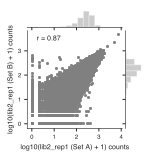

Day__Zero, rep 1, lib: lib1_rep1


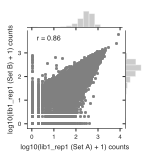

Day__Zero, rep 2, lib: lib2_rep2


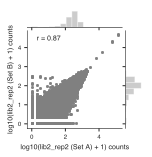

Day__Zero, rep 2, lib: lib1_rep2


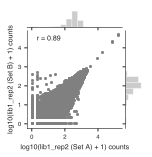

BFP+__Endo++, rep 1, lib: lib2_rep1


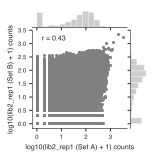

BFP+__Endo++, rep 1, lib: lib1_rep1


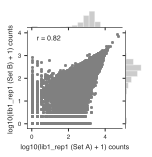

BFP+__Endo++, rep 2, lib: lib1_rep2


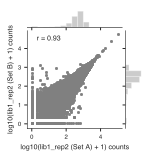

BFP+__Endo--, rep 2, lib: lib1_rep2


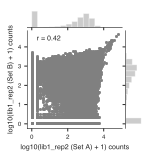

In [14]:
all_dfs = {"Day__Zero": [day0_rep1, day0_rep2], "BFP+__Endo++": [bfppos_endopos_rep1, bfppos_endopos_rep2], 
           "BFP+__Endo--": [bfppos_endoneg_rep1, bfppos_endoneg_rep2]}

for name in all_dfs:
    dfs = all_dfs[name]
    for i, df in enumerate(dfs):
        cols = [x for x in df.columns if x != "sgRNA"]
        
        # log transform data for plotting
        tmp = df.copy()
        tmp[cols] = np.log10(tmp[cols] + 1)
        
        # compare A & B seq from same library
        uniq_libs = list(set([x[:-2] for x in cols]))
        
        # edit cols for heatmap below
        new_cols = ["sgRNA"]
        cols = ["%s__%s" % (name, x) for x in cols]
        new_cols.extend(cols)
        df.columns = new_cols
        
        if "Endo--" in name and i == 0:
            continue
        
        for lib in uniq_libs:
            if "lib3" in lib:
                continue
                
            print("%s, rep %s, lib: %s" % (name, i+1, lib))
            col1 = "%s_a" % lib
            col2 = "%s_b" % lib
            
            # plot
            g = sns.jointplot(tmp[col1], tmp[col2], color="gray", size=2.2,
                              marginal_kws=dict(bins=15),
                              joint_kws=dict(s=5, rasterized=True))
            g.set_axis_labels("log10(%s (Set A) + 1) counts" % lib, "log10(%s (Set B) + 1) counts" % lib)
            
            # correlation
            r, p = spearmanr(tmp[col1], tmp[col2])
            g.ax_joint.annotate( "r = {:.2f}".format(r), ha="left", xy=(0.1, .90), xycoords=g.ax_joint.transAxes, 
                                fontsize=fontsize)

            #g.savefig("%s_%s_lib_corr_scatter.pdf" % (name, lib), dpi="figure", bbox_inches="tight")
            plt.show()

In [15]:
bfppos_counts = day0_rep1.merge(day0_rep2, on="sgRNA").merge(bfppos_endopos_rep1, on="sgRNA").merge(bfppos_endopos_rep2, on="sgRNA").merge(bfppos_endoneg_rep1, on="sgRNA").merge(bfppos_endoneg_rep2, on="sgRNA")

In [16]:
bfppos_counts.set_index("sgRNA", inplace=True)
bfppos_counts_corr = bfppos_counts.corr(method="spearman")

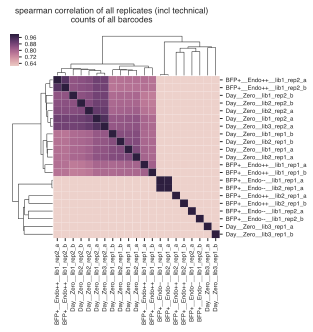

In [17]:
cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(bfppos_counts_corr, figsize=(3.75, 3.75), cmap=cmap, annot=False, vmin=0.6)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("spearman correlation of all replicates (incl technical)\ncounts of all barcodes")
#cg.savefig("BFP+_COUNTS__rep_and_lib_corr_heatmap.pdf", dpi="figure", bbox_inches="tight")

## 3. sum technical replicates

### day 0

In [18]:
day0_rep1["lib1_rep1"] = day0_rep1["Day__Zero__lib1_rep1_a"] + day0_rep1["Day__Zero__lib1_rep1_b"]
day0_rep1.drop(["Day__Zero__lib1_rep1_a", "Day__Zero__lib1_rep1_b"], axis=1, inplace=True)

day0_rep1["lib2_rep1"] = day0_rep1["Day__Zero__lib2_rep1_a"] + day0_rep1["Day__Zero__lib2_rep1_b"]
day0_rep1.drop(["Day__Zero__lib2_rep1_a", "Day__Zero__lib2_rep1_b"], axis=1, inplace=True)

day0_rep1["lib3_rep1"] = day0_rep1["Day__Zero__lib3_rep1_a"] + day0_rep1["Day__Zero__lib3_rep1_b"]
day0_rep1.drop(["Day__Zero__lib3_rep1_a", "Day__Zero__lib3_rep1_b"], axis=1, inplace=True)

day0_rep1["Day_Zero__rep1"] = day0_rep1["lib1_rep1"] + day0_rep1["lib2_rep1"] + day0_rep1["lib3_rep1"]
day0_rep1.drop(["lib1_rep1", "lib2_rep1", "lib3_rep1"], axis=1, inplace=True)
day0_rep1.head()

,sgRNA,Day_Zero__rep1
0,TTATCTGCATACTTATACAG,728
1,TATGCTTTATCCACTCCGAC,1016
2,TGAAAGCATAGGATATGGCA,1859
3,AATGGTAAGTTGCTGCTCAG,961
4,TAAGCATGCGTGGTATCAAG,2257


In [19]:
day0_rep2["lib1_rep2"] = day0_rep2["Day__Zero__lib1_rep2_a"] + day0_rep2["Day__Zero__lib1_rep2_b"]
day0_rep2.drop(["Day__Zero__lib1_rep2_a", "Day__Zero__lib1_rep2_b"], axis=1, inplace=True)

day0_rep2["lib2_rep2"] = day0_rep2["Day__Zero__lib2_rep2_a"] + day0_rep2["Day__Zero__lib2_rep2_b"]
day0_rep2.drop(["Day__Zero__lib2_rep2_a", "Day__Zero__lib2_rep2_b"], axis=1, inplace=True)

day0_rep2["Day_Zero__rep2"] = day0_rep2["lib1_rep2"] + day0_rep2["lib2_rep2"] + day0_rep2["Day__Zero__lib3_rep2_a"]
day0_rep2.drop(["lib1_rep2", "lib2_rep2", "Day__Zero__lib3_rep2_a"], axis=1, inplace=True)
day0_rep2.head()

,sgRNA,Day_Zero__rep2
0,ATCTTACAAGGTGTCTAGCC,1054
1,TGCCCATCATCTGGGATATG,1740
2,CCCCGAGGAGGGCGGCGCCC,2384
3,AAAAAAAACATATTTGGGCC,219
4,AGTTTCTCCCCATGAAAAAT,1853


In [20]:
day0 = day0_rep1.merge(day0_rep2, on="sgRNA")
day0.head()

,sgRNA,Day_Zero__rep1,Day_Zero__rep2
0,TTATCTGCATACTTATACAG,728,637
1,TATGCTTTATCCACTCCGAC,1016,1206
2,TGAAAGCATAGGATATGGCA,1859,2038
3,AATGGTAAGTTGCTGCTCAG,961,925
4,TAAGCATGCGTGGTATCAAG,2257,1383


### BFP+ endo++

In [21]:
bfppos_endopos_rep1["BFP+_Endo++__rep1"] = bfppos_endopos_rep1["BFP+__Endo++__lib1_rep1_a"] + bfppos_endopos_rep1["BFP+__Endo++__lib1_rep1_b"] + bfppos_endopos_rep1["BFP+__Endo++__lib2_rep1_a"] + bfppos_endopos_rep1["BFP+__Endo++__lib2_rep1_b"]
bfppos_endopos_rep1.drop(["BFP+__Endo++__lib1_rep1_a", "BFP+__Endo++__lib1_rep1_b", "BFP+__Endo++__lib2_rep1_a", "BFP+__Endo++__lib2_rep1_b"], axis=1, inplace=True)

bfppos_endopos_rep2["BFP+_Endo++__rep2"] = bfppos_endopos_rep2["BFP+__Endo++__lib1_rep2_a"] + bfppos_endopos_rep2["BFP+__Endo++__lib1_rep2_b"]
bfppos_endopos_rep2.drop(["BFP+__Endo++__lib1_rep2_a", "BFP+__Endo++__lib1_rep2_b"], axis=1, inplace=True)

bfppos_endopos = bfppos_endopos_rep1.merge(bfppos_endopos_rep2, on="sgRNA")
bfppos_endopos.head()

,sgRNA,BFP+_Endo++__rep1,BFP+_Endo++__rep2
0,GACCCGAAACCGTCCCCGGC,5686,2896
1,GCGGTTTAGCCGCTAGTCAA,1759,1147
2,TCGCTGAGAGCAGGAAACTA,1374,1013
3,TAGAATACTCAGGCCAGCCT,2317,673
4,CGGGCGACCTGGGCACCAGC,1883,951


### BFP+ endo--

In [22]:
bfppos_endoneg_rep1["BFP+_Endo--__rep1"] = bfppos_endoneg_rep1["BFP+__Endo--__lib1_rep1_a"] + bfppos_endoneg_rep1["BFP+__Endo--__lib2_rep1_a"]
bfppos_endoneg_rep1.drop(["BFP+__Endo--__lib1_rep1_a", "BFP+__Endo--__lib2_rep1_a"], axis=1, inplace=True)

bfppos_endoneg_rep2["BFP+_Endo--__rep2"] = bfppos_endoneg_rep2["BFP+__Endo--__lib1_rep2_a"] + bfppos_endoneg_rep2["BFP+__Endo--__lib1_rep2_b"]
bfppos_endoneg_rep2.drop(["BFP+__Endo--__lib1_rep2_a", "BFP+__Endo--__lib1_rep2_b"], axis=1, inplace=True)

bfppos_endoneg = bfppos_endoneg_rep1.merge(bfppos_endoneg_rep2, on="sgRNA")
bfppos_endoneg.head()

,sgRNA,BFP+_Endo--__rep1,BFP+_Endo--__rep2
0,CCGGAAAGCGCTGGTCTAGC,63,734
1,TGGAGCCTCGGAATACAGCC,2831,524
2,AGAGAAACAAGCCCTTTAAA,132,939
3,CTGGATGTGAATCCCAGGTC,630,1386
4,AGGGCGGCCGGAAGTGGCGT,0,255


## 4. compare biological replicates

Day_Zero


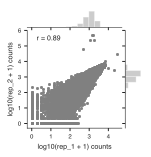

BFP+_Endo++


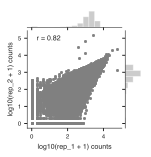

BFP+_Endo--


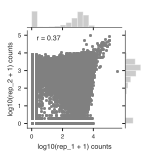

In [23]:
all_dfs = {"Day_Zero": day0, "BFP+_Endo++": bfppos_endopos, "BFP+_Endo--": bfppos_endoneg}

for name in all_dfs:
    print(name)
    df = all_dfs[name]
    cols = [x for x in df.columns if x != "sgRNA"]
        
    # log transform data for plotting
    tmp = df.copy()
    tmp[cols] = np.log10(tmp[cols] + 1)
            
    # plot
    g = sns.jointplot(tmp[cols[0]], tmp[cols[1]], color="gray", size=2.2,
                      marginal_kws=dict(bins=15),
                      joint_kws=dict(s=5, rasterized=True))
    g.set_axis_labels("log10(rep_1 + 1) counts", "log10(rep_2 + 1) counts")

    # correlation
    r, p = spearmanr(tmp[cols[0]], tmp[cols[1]])
    g.ax_joint.annotate( "r = {:.2f}".format(r), ha="left", xy=(0.1, .90), xycoords=g.ax_joint.transAxes, 
                        fontsize=fontsize)

    #g.savefig("%s_rep_corr_scatter.pdf" % (name), dpi="figure", bbox_inches="tight")
    plt.show()

In [24]:
bfppos_counts = day0.merge(bfppos_endopos, on="sgRNA").merge(bfppos_endoneg, on="sgRNA")

In [25]:
tmp = bfppos_counts.set_index("sgRNA")
bfppos_counts_corr = tmp.corr(method="spearman")

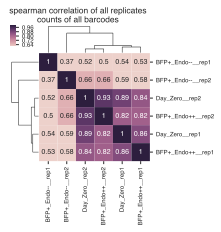

In [26]:
cg = sns.clustermap(bfppos_counts_corr, figsize=(2.5, 2.5), cmap=cmap, annot=True, vmin=0.6)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("spearman correlation of all replicates\ncounts of all barcodes")
cg.savefig("FigS5B.pdf", dpi="figure", bbox_inches="tight")

## 5. normalize for sequencing depth

In [27]:
all_counts = pseudocount(bfppos_counts)
all_counts = to_cpm(all_counts)
all_counts.head()

,sgRNA,Day_Zero__rep1,Day_Zero__rep2,BFP+_Endo++__rep1,BFP+_Endo++__rep2,BFP+_Endo--__rep1,BFP+_Endo--__rep2
0,TTATCTGCATACTTATACAG,5.365861,4.437782,4.303655,4.272027,0.006844,3.724984
1,TATGCTTTATCCACTCCGAC,7.485707,8.395616,8.191882,7.448142,4.524157,2.469132
2,TGAAAGCATAGGATATGGCA,13.690673,14.182817,11.860725,10.817056,11.847680,7.130683
3,AATGGTAAGTTGCTGCTCAG,7.080875,6.441044,9.624878,7.701825,10.074977,8.897390
4,TAAGCATGCGTGGTATCAAG,16.620183,9.626787,11.944744,9.355840,8.562362,0.007095


In [28]:
all_counts_norm = all_counts

## 6. join w/ index and write file

In [29]:
data = index.merge(all_counts_norm, on="sgRNA")
len(data)

111801

In [30]:
data.sample(5)

,sgRNA,count,tss_id_hg38,transcript_id,transcript_name,gene_id,gene_name,tss_type,cage_id_hg19,sgRNA_qual,...,sgRNA_id,ctrl_status,oligo,oligo_len,Day_Zero__rep1,Day_Zero__rep2,BFP+_Endo++__rep1,BFP+_Endo++__rep2,BFP+_Endo--__rep1,BFP+_Endo--__rep2
18311,CATCATCCCATGGCAGAAGT,1,NC_000003.12:-:131330875,ENST00000511699.1_1,RP11-933H2.4-002,ENSG00000250608.1_1,RP11-933H2.4,FANTOM CAT assignment,"chr3:131049719..131049720,-",good,...,sgRNA:034506__gene:RP11-933H2.4,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGCATCATCCCATGGCAG...,85,10.268005,14.127171,10.595768,15.373208,17.446411,14.381985
55476,GGGTCCTTAGCTACCCACTT,1,NC_000011.10:-:115759350,ENST00000602803.1_1,LINC00900-006,ENSG00000246100.3_1,LINC00900,FANTOM CAT assignment,"chr11:115630068..115630069,-",good,...,sgRNA:075952__gene:LINC00900,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGGGGTCCTTAGCTACCC...,85,11.740120,13.375948,15.030120,16.590888,18.637339,19.873676
22355,TACCCAAAGTCAGTTGACAA,1,NC_000003.12:-:51953901,ENST00000624646.1_1,RP11-155D18.13-001,ENSG00000280422.1_1,RP11-155D18.13,annotation,none,good,...,sgRNA:084663__gene:RP11-155D18.13,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGTACCCAAAGTCAGTTG...,85,5.991510,4.848172,8.794021,4.769246,0.006844,5.654880
33756,TCTTGGATACAGAGCCATCG,1,NC_000006.12:+:125674352,ENST00000423208.2_1,RP1-293L8.2-001,ENSG00000224506.2_1,RP1-293L8.2,FANTOM CAT assignment,"chr6:125995498..125995499,+",good,...,sgRNA:092878__gene:RP1-293L8.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGTCTTGGATACAGAGCC...,85,8.236486,9.376379,4.364336,8.280223,10.862085,2.149848
20401,TACCTAACAAAGGCCTGAAG,1,NC_000003.12:-:186745834,ENST00000609726.5_1,RP11-573D15.8-006,ENSG00000197099.8_1,RP11-573D15.8,annotation,none,good,...,sgRNA:084739__gene:RP11-573D15.8,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGTACCTAACAAAGGCCT...,85,4.224971,5.787201,6.637525,6.697239,1.642659,3.164462


In [31]:
# write column with enrichment per guide (just foldchange between endo-- and endo++)
data["BFP+_enrichment__rep1"] = data["BFP+_Endo--__rep1"]/data["BFP+_Endo++__rep1"]
data["BFP+_enrichment__rep2"] = data["BFP+_Endo--__rep2"]/data["BFP+_Endo++__rep2"]

data["BFP+_enrichment__mean"] = data[["BFP+_enrichment__rep1", "BFP+_enrichment__rep2"]].mean(axis=1)
data.replace(np.inf, np.nan, inplace=True)

data = data.sort_values(by="BFP+_enrichment__mean", ascending=False)
data.head()

,sgRNA,count,tss_id_hg38,transcript_id,transcript_name,gene_id,gene_name,tss_type,cage_id_hg19,sgRNA_qual,...,oligo_len,Day_Zero__rep1,Day_Zero__rep2,BFP+_Endo++__rep1,BFP+_Endo++__rep2,BFP+_Endo--__rep1,BFP+_Endo--__rep2,BFP+_enrichment__rep1,BFP+_enrichment__rep2,BFP+_enrichment__mean
76292,AGGAGGGCCCGCCGGAGGAG,2,NC_000015.10:+:89378103,"['ENST00000559235.5_1', 'ENST00000560596.5_1']","['MIR9-3HG-010', 'MIR9-3HG-012']",ENSG00000255571.7_2,MIR9-3HG,closest CAGE,"chr15:89921324..89921360,+",good,...,85,0.618288,0.466037,0.004668,0.010147,15.064555,1.312613,3227.377149,129.355511,1678.366330
105641,GGACCCACCGGGCGGAGGAG,1,NC_000023.11:-:24149637,ENST00000427551.1_1,ZFX-AS1-001,ENSG00000234230.1_1,ZFX-AS1,FANTOM CAT assignment,"chrX:24167737..24167762,-",good,...,85,0.772861,0.146071,0.009335,0.010147,24.010203,1.738326,2571.930722,171.308650,1371.619686
49722,AAGAACCCTCCACCACACCC,2,NC_000009.12:+:62801486,"['ENST00000424345.5_1', 'ENST00000427509.5_1']","['LINC01410-001', 'LINC01410-003']",ENSG00000238113.6_1,LINC01410,closest CAGE,"chr9:66457285..66457319,+",good,...,85,3.326981,3.686559,0.004668,0.730608,12.662165,0.007095,2712.697740,0.009711,1356.353726
33836,CAGGCCAAGGGAGTAGAAGG,1,NC_000006.12:+:131902940,ENST00000419695.1_1,RP11-69I8.2-003,ENSG00000236673.5_2,RP11-69I8.2,FANTOM CAT assignment,"chr6:132224075..132224083,+",good,...,85,2.679250,0.403435,0.004668,0.010147,11.471237,0.007095,2457.557520,0.699219,1229.128370
21491,GCAATTGAAAAAGGGCAGAA,1,NC_000003.12:-:27722707,ENST00000461503.2_1,EOMES-004,ENSG00000163508.12_1,EOMES,closest CAGE,"chr3:27764190..27764208,-",good,...,85,9.679159,9.918929,0.004668,0.375451,11.156394,18.844870,2390.106657,50.192584,1220.149621


In [32]:
f = "../../../data/02__screen/01__normalized_counts/normalized_sgRNA_counts.txt"
data.to_csv(f, sep="\t", index=False)